In [ ]:
!pip install 'aif360[LFR]' fairlearn gpflow

In [4]:
cd /usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult

/usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult


In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test

In [2]:
import numpy as np
import tensorflow as tf
#from tensorflow import keras
import time
import pandas as pd

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels



import copy


from aif360.datasets import AdultDataset
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult
from aif360.metrics import ClassificationMetric
from aif360.sklearn.metrics import equal_opportunity_difference
from aif360.sklearn.datasets import standardize_dataset

import gpflow

from gpflow.utilities import print_summary, set_trainable
from gpflow.ci_utils import ci_niter

import warnings
warnings.filterwarnings("ignore")

np.random.seed(0)
tf.random.set_seed(123)

In [16]:
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]
adult_dataset = load_preproc_data_adult(['sex'])

#train, test = dataset_orig.split([0.7], shuffle=True, seed=3)
#print("training data size", train.features.shape)
#print("dataset feature names", train.feature_names)

#data_preprocessing = Pipeline([("standardiser", StandardScaler()),
                               #("minmaxscaler", MinMaxScaler()),
                                # ]
                                # )


adult_income_data, adult_dict = adult_dataset.convert_to_dataframe()

X, y = standardize_dataset(df=adult_income_data, prot_attr='sex', target='Income Binary')

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.30,
    random_state=42
    )

In [17]:
# x_train = train.features
# x_test = test.features
# # x_train = data_preprocessing.fit_transform(train.features)
# # x_test = data_preprocessing.fit_transform(test.features)
# y_train = train.labels.ravel()
# y_test = test.labels.ravel()

#training_data = (x_train, y_train)


# N = len(x_train)
# M = 400
print("Number of training datapoints:", len(X_train))
print("Number of features", len(X.columns))

Number of training datapoints: 34189
Number of features 18


## Model Training

### Setting up the model

In [22]:
class SVGP_classifier(ClassifierMixin, BaseEstimator):
    """ A multiclass classifier that uses SVGP (Hensman, 2013).

    Parameters
    ----------
    M : int, default=100
        The number of inducing points to be used (comuptation scales as O(M^3)).

    Attributes
    ----------
    X_ : ndarray, shape (n_samples, n_features)
        The input passed during :meth:`fit`.
    y_ : ndarray, shape (n_samples,)
        The labels passed during :meth:`fit`.
    classes_ : ndarray, shape (n_classes,)
        The classes seen at :meth:`fit`.
    """
    def __init__(self, M=100):
        self.M = M

        self.elbo_training_log = []
        self.fairness_log = []
        

    def run_adam(self, model, iterations, training_data, minibatch_size):
        """
        Utility function running the Adam optimizer

        :param model: GPflow model
        :param interations: number of iterations
        """
        # Create an Adam Optimizer action
        train_dataset = tf.data.Dataset.from_tensor_slices(training_data).repeat().shuffle(self.N)
        logf = []
        train_iter = iter(train_dataset.batch(minibatch_size))
        training_loss = model.training_loss_closure(train_iter, compile=True)
        optimizer = tf.optimizers.Adam()

        @tf.function
        def optimization_step():
            optimizer.minimize(training_loss, model.trainable_variables)

        for step in range(iterations):
            optimization_step()
            if step % 10 == 0:
                elbo = -training_loss().numpy()
                logf.append(elbo/minibatch_size)
        return logf    


    def fit(self, X, y, minibatch_size=130, total_iterations=10000, show_training_curve=False, show_training_summary=False, robustmax_epsilon=0.001):
        """A reference implementation of a fitting function for a classifier.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The training input samples.
        y : array-like, shape (n_samples,)
            The target values. An array of int.
        minibatch_size : int, 

        Returns
        -------
        self : object
            Returns self.
        """
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
        self.N = len(y)
        self.C = len(self.classes_)


        kernel_multi = gpflow.kernels.Matern52() + gpflow.kernels.White(variance=0.01)

        # Robustmax Multiclass Likelihood
        
        invlink = gpflow.likelihoods.RobustMax(
            self.C,
            epsilon=robustmax_epsilon
            )  # Robustmax inverse link function

        likelihood_multi = gpflow.likelihoods.MultiClass(
            self.C,
            invlink=invlink
            )  # Multiclass likelihood

        Z = X[::self.M].copy()  # inducing inputs

        self.m = gpflow.models.SVGP(
            kernel=kernel_multi,
            likelihood=likelihood_multi,
            inducing_variable=Z,
            num_latent_gps=self.C,
            whiten=True,
            q_diag=True,
        )

        set_trainable(self.m.kernel.kernels[0].variance, False)
        set_trainable(self.m.inducing_variable, False)



        self.mb_size = minibatch_size
        training_data = (X, y)
        maxiter = ci_niter(total_iterations)
        self.elbo_training_log = self.run_adam(
            self.m,
            maxiter,
            training_data,
            self.mb_size)
        
        if show_training_curve==True:
            plt.plot(np.linspace(0, total_iterations, len(self.elbo_training_log)), self.elbo_training_log)
            plt.xlabel("Iteration")
            plt.ylabel("ELBO per data point")
            plt.title("Training curve")
            plt.show()

        if show_training_summary==True:
            print_summary(self.m, fmt="notebook")

        # Return the classifier
        return self


    def predict(self, X_test):
        """ A reference implementation of a prediction for a classifier.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            The label for each sample is the label of the closest sample
            seen during fit.
        """
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])

        # Input validation
        X_test = check_array(X_test)

        mu, _ = self.m.predict_y(X_test)
        predictions = []
        for probs in mu:
            prediction = np.argmax(probs)
            predictions.append(prediction)
        return predictions


    # def eq_opp_fairness(self, X_test, y_test):
    #     from fairlearn.metrics import true_positive_rate

    #     predictions = self.predict(X_test)
    #     female_test = []
    #     male_test = []
    #     female_pred = []
    #     male_pred = []
    #     for i, index in enumerate(list(y_test.index)):
    #         if index[1]==0:
    #             female_test.append(y_test[index])
    #             female_pred.append(predictions[i])
    #         if index[1]==1:
    #             male_test.append(y_test[index])
    #             male_pred.append(predictions[i])
    #     tpr_male = true_positive_rate(male_test, male_pred)
    #     tpr_female = true_positive_rate(female_test, female_pred)
    #     return tpr_female-tpr_male



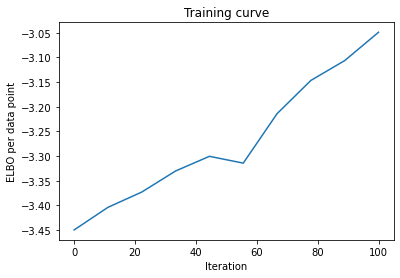

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,False,(),float64,1.0
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.084495644708273
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.011366863195713171
SVGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
SVGP.inducing_variable.Z,Parameter,Identity,,False,"(86, 18)",float64,"[[1., 1., 0...."
SVGP.q_mu,Parameter,Identity,,True,"(86, 2)",float64,"[[0.10308986, -0.10308986..."
SVGP.q_sqrt,Parameter,Softplus,,True,"(86, 2)",float64,"[[0.91910677, 0.91910677..."


SVGP_classifier(M=400)

In [20]:
classify_me = SVGP_classifier(400)
classify_me.fit(X_train, y_train, minibatch_size=100, total_iterations=100, show_training_curve=True)



### Training the models

In [25]:
print(classify_me.eq_opp_fairness(X_test[:100], y_test[:100]))

-0.26666666666666666


In [21]:
from fairlearn.metrics import true_positive_rate

def tpr_differ(y_test, predictions):
    female_test = []
    male_test = []
    female_pred = []
    male_pred = []
    for i, index in enumerate(list(y_test.index)):
        if index[1]==0:
            female_test.append(y_test[index])
            female_pred.append(predictions[i])
        if index[1]==1:
            male_test.append(y_test[index])
            male_pred.append(predictions[i])
    tpr_male = true_positive_rate(male_test, male_pred)
    tpr_female = true_positive_rate(female_test, female_pred)
    return tpr_female-tpr_male


In [18]:
# mb_sizes = list(np.linspace(10, 500, 50, dtype=int))
# print(mb_sizes)

epsilons = [0.001, 0.01, 0.1]#range(0.001, 510, 10)

scoring_metrics = {"accuracy": "accuracy", "equal_opportunity_difference": make_scorer(tpr_differ)}

score_log = []

with tf.device('/device:GPU:0'):
    for epsilon in epsilons:
        print(epsilon)
        svgpclass = SVGP_classifier(400)
        scores = cross_validate(svgpclass, X_train, y_train, scoring=scoring_metrics, cv=5, fit_params={"robustmax_epsilon": epsilon, "total_iterations":10000})
        print("RobustMax epsilon:", epsilon, "\n", "average accuracy:",np.mean(scores["test_accuracy"]), "     Average equal opportunity difference:",np.mean(scores["test_equal_opportunity_difference"]))
        score_log.append(scores)


10
Minibatch size: 10 
 average accuracy: 0.7581970818161062      Average equal opportunity difference: 0.0
20
Minibatch size: 20 
 average accuracy: 0.7581970818161062      Average equal opportunity difference: 0.0
30
Minibatch size: 30 
 average accuracy: 0.7581970818161062      Average equal opportunity difference: 0.0
40
Minibatch size: 40 
 average accuracy: 0.7581970818161062      Average equal opportunity difference: 0.0
50
Minibatch size: 50 
 average accuracy: 0.7581970818161062      Average equal opportunity difference: 0.0
60
Minibatch size: 60 
 average accuracy: 0.7660063827813008      Average equal opportunity difference: -0.08679514632405425
70
Minibatch size: 70 
 average accuracy: 0.7724712065344088      Average equal opportunity difference: -0.13902536215139238
80
Minibatch size: 80 
 average accuracy: 0.8007545355962129      Average equal opportunity difference: -0.4269792499407056
90
Minibatch size: 90 
 average accuracy: 0.8007252872779912      Average equal opport

KeyboardInterrupt: ignored

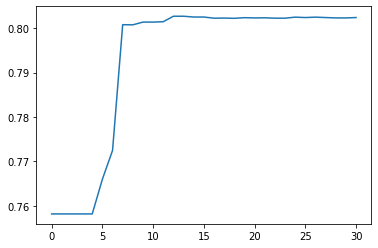

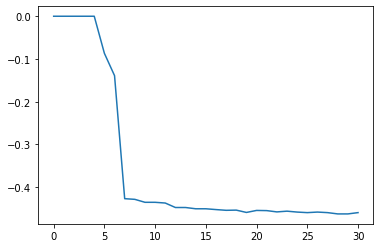

In [20]:
accuracies = []
fairnesses = []

for score in score_log:
    fairness = np.mean(score["test_equal_opportunity_difference"])
    accuracy = np.mean(score["test_accuracy"])
    accuracies.append(accuracy)
    fairnesses.append(fairness)

plt.plot(accuracies)
plt.show()

plt.plot(fairnesses)
plt.show()

In [ ]:



# elbo_training_logs = []
# models = []


# with tf.device('/device:GPU:0'):
#     for mb_size in mb_sizes:
#         model = copy.deepcopy(m)
#         elbo_training_log = run_adam(model, maxiter, training_data, mb_size)
#         elbo_training_logs.append(np.array(elbo_training_log)/mb_size)
#         models.append(model)


# for log in elbo_training_logs:
#     plt.plot(range(0, total_iterations, 10), log)
#     plt.show()

In [ ]:





# def calculate_test_accuracy(model, x_test, y_test):
#     predictions = predict_targets(model, x_test)
#     total_correct = 0
#     for i in range(len(x_test)):
#         if predictions[i]==y_test[i]:
#             total_correct += 1

#     return total_correct/len(predictions)


# def logistic_regression_accuracy(training_data, x_test, y_test):
#     model = LogisticRegression()
#     model.fit(*training_data)
#     predictions = model.predict(x_test)
#     return accuracy_score(y_test, predictions)

# def mlp_accuracy(training_data, x_test, y_test):
#     model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
#     model.fit(*training_data)
#     predictions = model.predict(x_test)
#     return accuracy_score(y_test, predictions)


# fairness_scores = []
# test_accuracies = []

# for i in range(len(models)):
#     test_accuracy = calculate_test_accuracy(models[i], x_test, y_test)
#     print(f"SVGP accuracy (minibatch = {mb_sizes[i]}):", test_accuracy)
#     test_accuracies.append(test_accuracy)
#     predictions = predict_targets(models[i], x_test)
#     test_pred = test.copy()
#     test_pred.labels = np.array(predictions)
#     fairness_metric = ClassificationMetric(
#         test, 
#         test_pred,
#         unprivileged_groups=unprivileged_groups, 
#         privileged_groups=privileged_groups
#         )
#     fairness_scores.append(fairness_metric.equal_opportunity_difference())
# print("Logistic Regression accuracy:", logistic_regression_accuracy(training_data, x_test, y_test))
# print("MLP accuracy:", mlp_accuracy(training_data, x_test, y_test))

